# ML & Web scraping

### Data set used for ML part was created during Web Scrapping process.<br>
### For ML PART: code is as a MARKDOWN to keep data and results as they are shown in the report. Please load attached file created as a result of web scrapping.
### For Programming: please remove mardown and use web scrapping code.

In [1]:
# loading libraries
import requests
from bs4 import BeautifulSoup 
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV

# getting a User-Agent from https://httpbin.org/get
headers = { "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36 Edg/105.0.1343.27", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}


baseurl = 'https://www.property.ie/property-for-sale/dublin/price_0-950000/'

productlinks = []
for x in range(1,120):
    r = requests.get(f'https://www.property.ie/property-for-sale/dublin/price_0-950000/p_{x}/')
    soup = BeautifulSoup(r.content, 'html.parser')
    productlist = soup.find_all('div', class_='search_result')

    for item in productlist:
        link = item.find('a', href=True)
        if link:
            productlinks.append(link['href'])

print(productlinks)

House = []
for link in productlinks:
    r = requests.get(link, headers=headers)
    soup = BeautifulSoup(r.content, 'lxml')
    
# address
    address = soup.find('h1', style = 'clear: left').text.strip()
    
    
# pulling the data
    na = soup.find("div", id="searchmoreinfo_summary")
    name = na.get_text(strip=True)
    
    
# extract price
    price_match = re.search(r'€([\d,]+)',name)
    if price_match:
        price = price_match.group(1)
    else:
        price = None

# pulling the number of bedrooms and bathrooms
    bedrooms_match = re.search(r'(\d+) Bedrooms', name)
    if bedrooms_match:
        bedrooms = bedrooms_match.group(1)
    else:
        bedrooms = None

    bathrooms_match = re.search(r'(\d+) Bathrooms', name)
    if bathrooms_match:
        bathrooms = bathrooms_match.group(1)
    else:
        bathrooms = None

# extracting house type
    house_type_match = re.search(r'(\w+ House)', name)
    if house_type_match:
        house_type = str(house_type_match.group(1))
    else:
        house_type = None
        
    
    if house_type is not None:
        house_type.startswith('000')
        house_type = house_type.lstrip('0')
    else:
        house_type = None


# creating a dictionary with the extracted information
    info = {'Address':address,
        'Price': price,
        'Bedrooms': bedrooms,
        'Bathrooms': bathrooms,
        'House Type': house_type
}
    House.append(info)
    print(info)

# saving data as dataFrame
df_Dublin = pd.DataFrame(House)

In [ ]:
# saving file into and excel file
# df_Dublin.to_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Dublin_Houses.xlsx', index=False)

In [2]:
# loading data set
df_Dublin = pd.read_excel('C:\\ESTERA\\CA2\\data sets - IRL\\Dublin_Houses.xlsx')

df_Dublin.head()

,Address,Price,Bedrooms,Bathrooms,House Type
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House


In [3]:
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Address     1101 non-null   object 
 1   Price       1101 non-null   object 
 2   Bedrooms    975 non-null    float64
 3   Bathrooms   619 non-null    float64
 4   House Type  693 non-null    object 
dtypes: float64(2), object(3)
memory usage: 43.1+ KB


In [4]:
# splitting the address data 
split_address = df_Dublin['Address'].str.rsplit(', ', n=2, expand=True)
df_Dublin[['District', 'Area', 'Street']] = split_address.iloc[:, ::-1]
df_Dublin.head()

,Address,Price,Bedrooms,Bathrooms,House Type,District,Area,Street
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House,Dublin 15,Castleknock,"67 Park Drive Avenue, Castleknock"
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House,None,Dublin 3,109 Clonliffe Avenue
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House,Co. Dublin,Skerries,"2a Ballykea Close, Ballykea"
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House,Co. Dublin,Dun Laoghaire,77 Kill Avenue
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House,Co. Dublin,Swords,13a Hilltown Lawn


In [5]:
# moving all values from Area column to District column if there is word 'Dublin' in it
df_Dublin.loc[df_Dublin['Area'].str.contains(r'\bDublin\b', na=False), 'District'] = df_Dublin['Area']
df_Dublin['Area'] = df_Dublin['Area'].str.replace(r'\bDublin\b', '')
df_Dublin.head()

C:\Users\ester\AppData\Local\Temp\ipykernel_9100\2206455085.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_Dublin['Area'] = df_Dublin['Area'].str.replace(r'\bDublin\b', '')


,Address,Price,Bedrooms,Bathrooms,House Type,District,Area,Street
0,"67 Park Drive Avenue, Castleknock, Castleknock...","550,000",3.0,2.0,Terraced House,Dublin 15,Castleknock,"67 Park Drive Avenue, Castleknock"
1,"109 Clonliffe Avenue, Dublin 3","310,000",2.0,NaN,Terraced House,Dublin 3,3,109 Clonliffe Avenue
2,"2a Ballykea Close, Ballykea, Skerries, Co. Dublin","775,000",4.0,3.0,Detached House,Co. Dublin,Skerries,"2a Ballykea Close, Ballykea"
3,"77 Kill Avenue, Dun Laoghaire, Co. Dublin","795,000",4.0,5.0,Detached House,Co. Dublin,Dun Laoghaire,77 Kill Avenue
4,"13a Hilltown Lawn, Swords, Co. Dublin","449,000",3.0,3.0,Detached House,Co. Dublin,Swords,13a Hilltown Lawn


In [6]:
# dropping unnecessary columns
df_Dublin.drop(columns=['Address', 'Area', 'Street'], inplace=True)

In [7]:
# dropping all none values
df_Dublin = df_Dublin.dropna()

In [8]:
# removing "," sign
df_Dublin['Price'] = df_Dublin['Price'].str.replace(',', '')

In [9]:
# checking column types
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 1099
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       430 non-null    object 
 1   Bedrooms    430 non-null    float64
 2   Bathrooms   430 non-null    float64
 3   House Type  430 non-null    object 
 4   District    430 non-null    object 
dtypes: float64(2), object(3)
memory usage: 20.2+ KB


In [10]:
# converting object columns to int
columns_to_convert = ['Price', 'Bedrooms', 'Bathrooms']
df_Dublin.loc[:, columns_to_convert] = df_Dublin.loc[:, columns_to_convert].astype(int)

In [11]:
# checking how many unique types of house
df_Dublin['House Type'].unique()

array(['Terraced House', 'Detached House', 'Terrace House',
       '950Terraced House', '950Detached House'], dtype=object)

In [12]:
# correcting errors withing 'House Type' column
Terraced = ['Terraced House','950Terraced House']
df_Dublin['House Type'] = df_Dublin['House Type'].replace(Terraced, 'Terrace House')
df_Dublin['House Type'] = df_Dublin['House Type'].replace('950Detached House', 'Detached House')
df_Dublin['House Type'].unique()

array(['Terrace House', 'Detached House'], dtype=object)

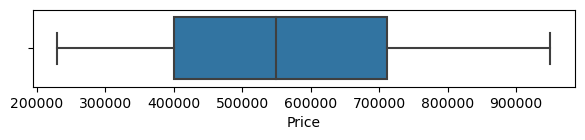

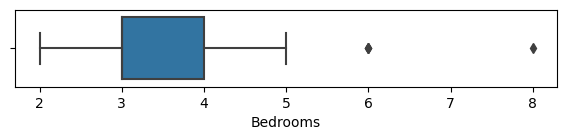

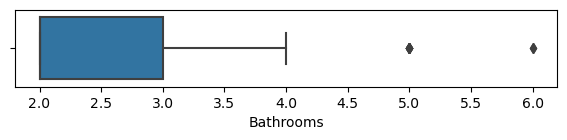

In [13]:
# creating boxplots to visualise data

import matplotlib.pyplot as plt

# selecting only non-object columns
numeric_columns = df_Dublin.select_dtypes(exclude='object').columns


for column in df_Dublin[numeric_columns]:
        plt.figure(figsize=(7,1))
        sns.boxplot(data=df_Dublin[numeric_columns], x=column)
       # plt.show()

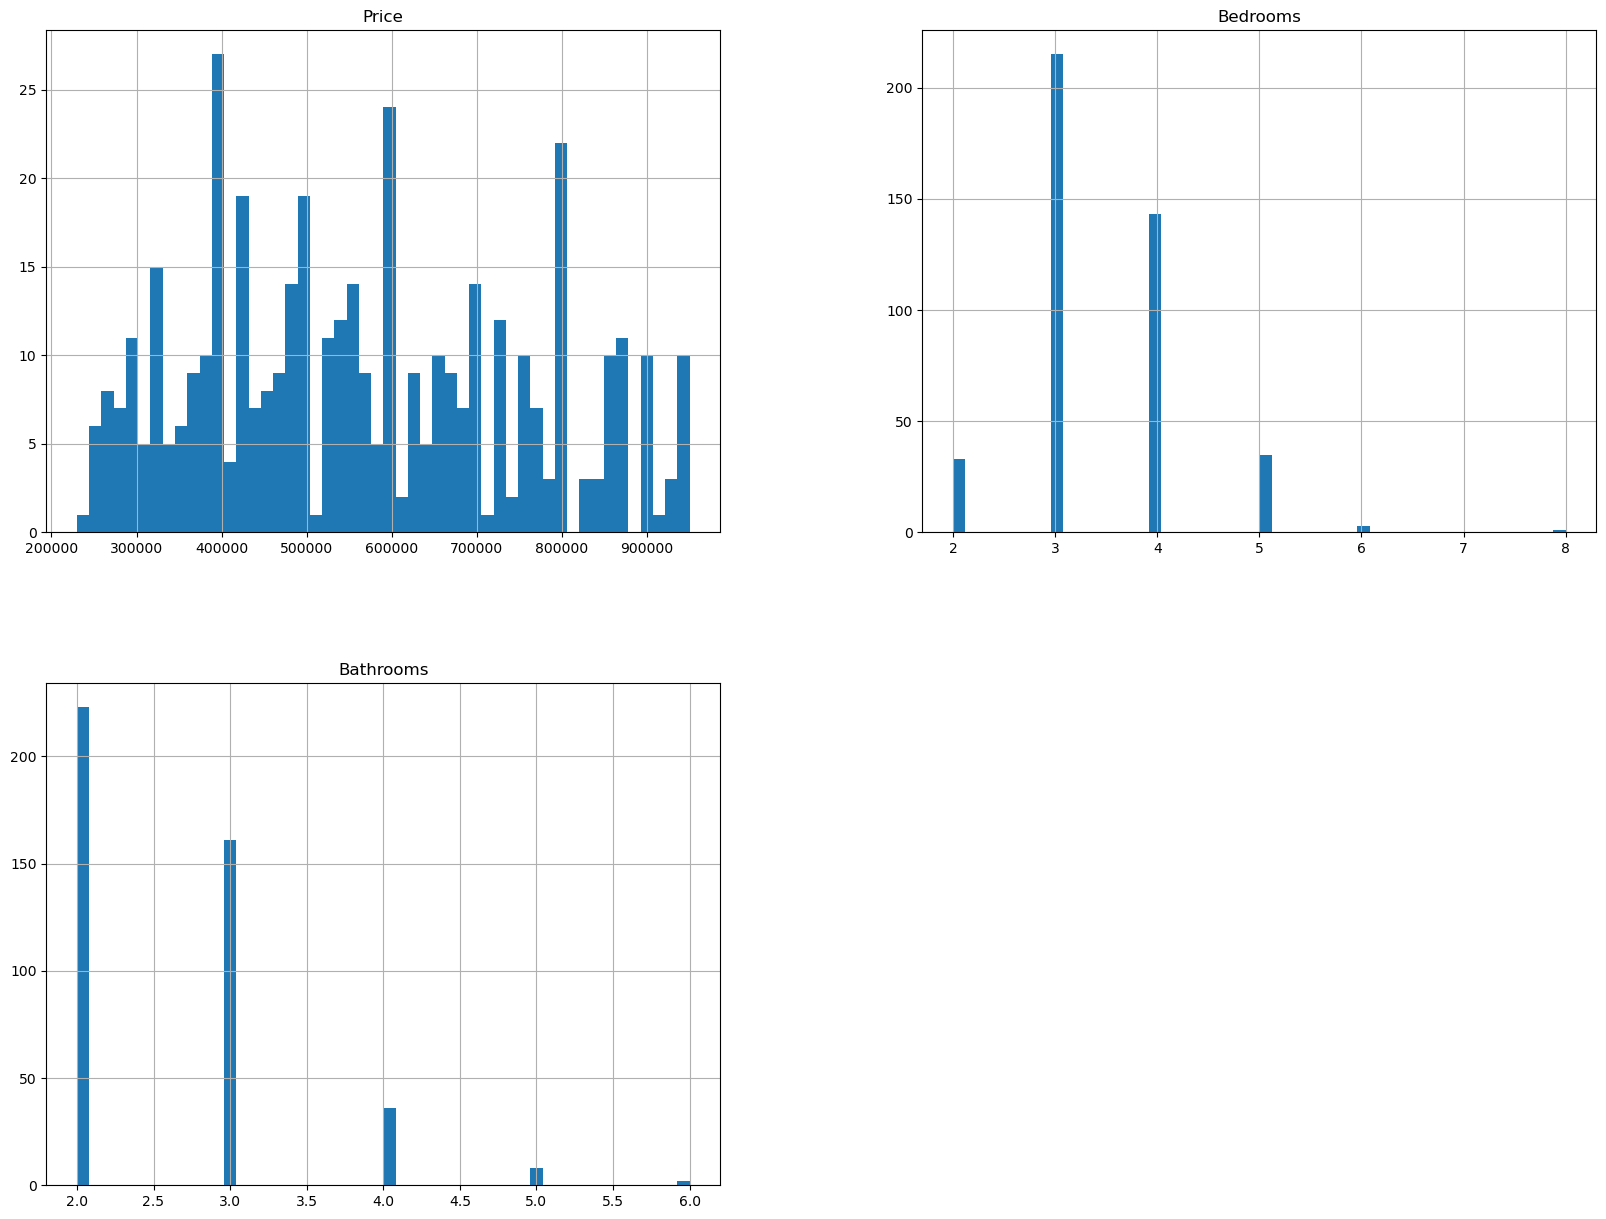

In [14]:
# creating a histograms
df_Dublin.hist(bins=50, figsize=(20,15))
plt.show()

## 2. Binary Classification
### 2.1. Preparing data

In [15]:
# getting dummies for 'House Type' column
df_Dublin = pd.get_dummies(df_Dublin, columns=['House Type'])
df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House
0,550000,3,2,Dublin 15,0,1
2,775000,4,3,Co. Dublin,1,0
3,795000,4,5,Co. Dublin,1,0
4,449000,3,3,Co. Dublin,1,0
5,545000,4,2,Co. Dublin,1,0


In [16]:
# modifing 'District' column
df_Dublin['District'] = df_Dublin['District'].apply(lambda x: 'County' if 'Co.' in x else 'Dublin' if 'Dublin' in x else x)
df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House
0,550000,3,2,Dublin,0,1
2,775000,4,3,County,1,0
3,795000,4,5,County,1,0
4,449000,3,3,County,1,0
5,545000,4,2,County,1,0


In [17]:
df_Dublin['Price'].describe()

count       430.000000
mean     564768.476744
std      189067.267221
min      230000.000000
25%      400000.000000
50%      549975.000000
75%      711000.000000
max      950000.000000
Name: Price, dtype: float64

In [18]:
# creating a price rangne groups
start_value = 230000
end_value = 950000
num_groups = 5  # Number of groups to create

# calculating the step size to evenly divide the range
step_size = (end_value - start_value) / num_groups

# defining the range labels for each group
range_labels = [f"{start_value + i * step_size}-{start_value + (i + 1) * step_size}" for i in range(num_groups)]

# creating the groups
groups = pd.cut(df_Dublin['Price'], bins=num_groups, labels=False)

# creating separate columns for each group using get_dummies and name the columns
group_columns = pd.get_dummies(groups, prefix='Price_Group')
group_columns.columns = ['Price_Group_' + range_labels[i] for i in range(num_groups)]

# concatenating the group columns with the original DataFrame
df_Dublin = pd.concat([df_Dublin, group_columns], axis=1)

df_Dublin.head()

,Price,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0
0,550000,3,2,Dublin,0,1,0,0,1,0,0
2,775000,4,3,County,1,0,0,0,0,1,0
3,795000,4,5,County,1,0,0,0,0,1,0
4,449000,3,3,County,1,0,0,1,0,0,0
5,545000,4,2,County,1,0,0,0,1,0,0


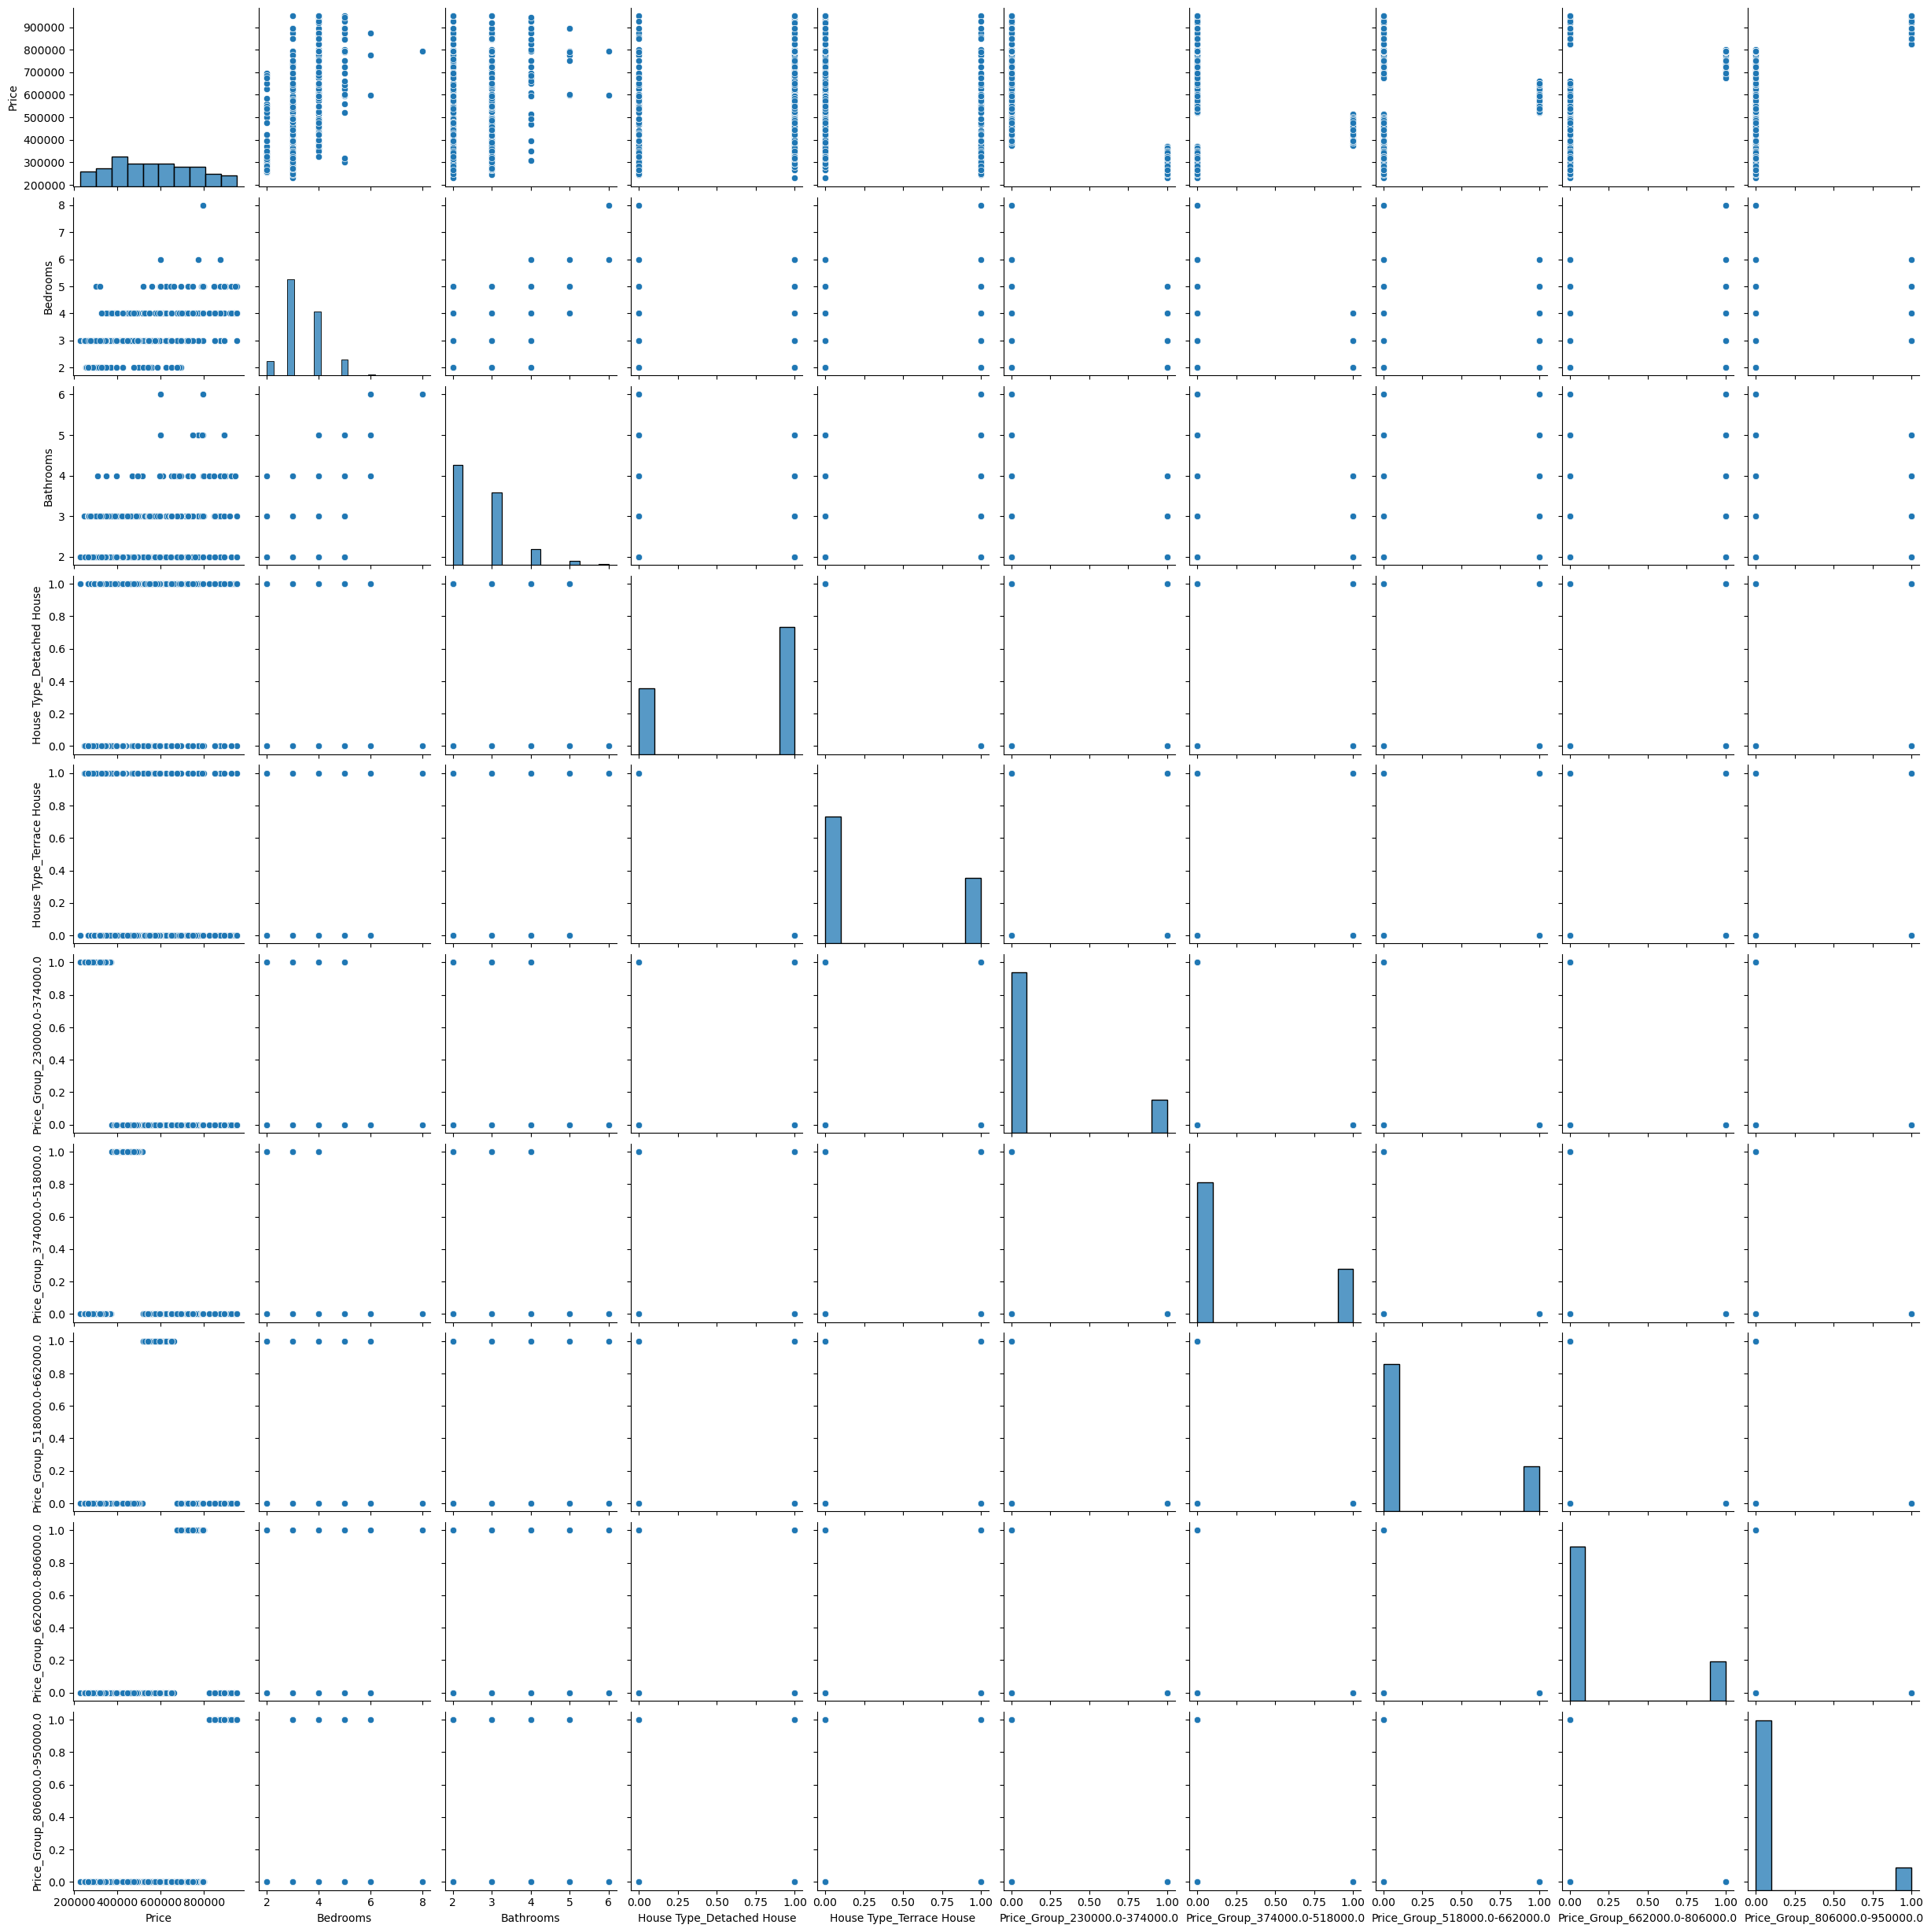

In [19]:
# creating a pair plot to see type of relationships between variables

# selecting only numerical columns
numerical_cols = df_Dublin.select_dtypes(include='number')

sns.pairplot(numerical_cols)
plt.show()

In [20]:
df_Dublin.drop('Price', axis=1, inplace=True)

In [21]:
df_Dublin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Bedrooms                       430 non-null    int32 
 1   Bathrooms                      430 non-null    int32 
 2   District                       430 non-null    object
 3   House Type_Detached House      430 non-null    uint8 
 4   House Type_Terrace House       430 non-null    uint8 
 5   Price_Group_230000.0-374000.0  430 non-null    uint8 
 6   Price_Group_374000.0-518000.0  430 non-null    uint8 
 7   Price_Group_518000.0-662000.0  430 non-null    uint8 
 8   Price_Group_662000.0-806000.0  430 non-null    uint8 
 9   Price_Group_806000.0-950000.0  430 non-null    uint8 
dtypes: int32(2), object(1), uint8(7)
memory usage: 29.2+ KB


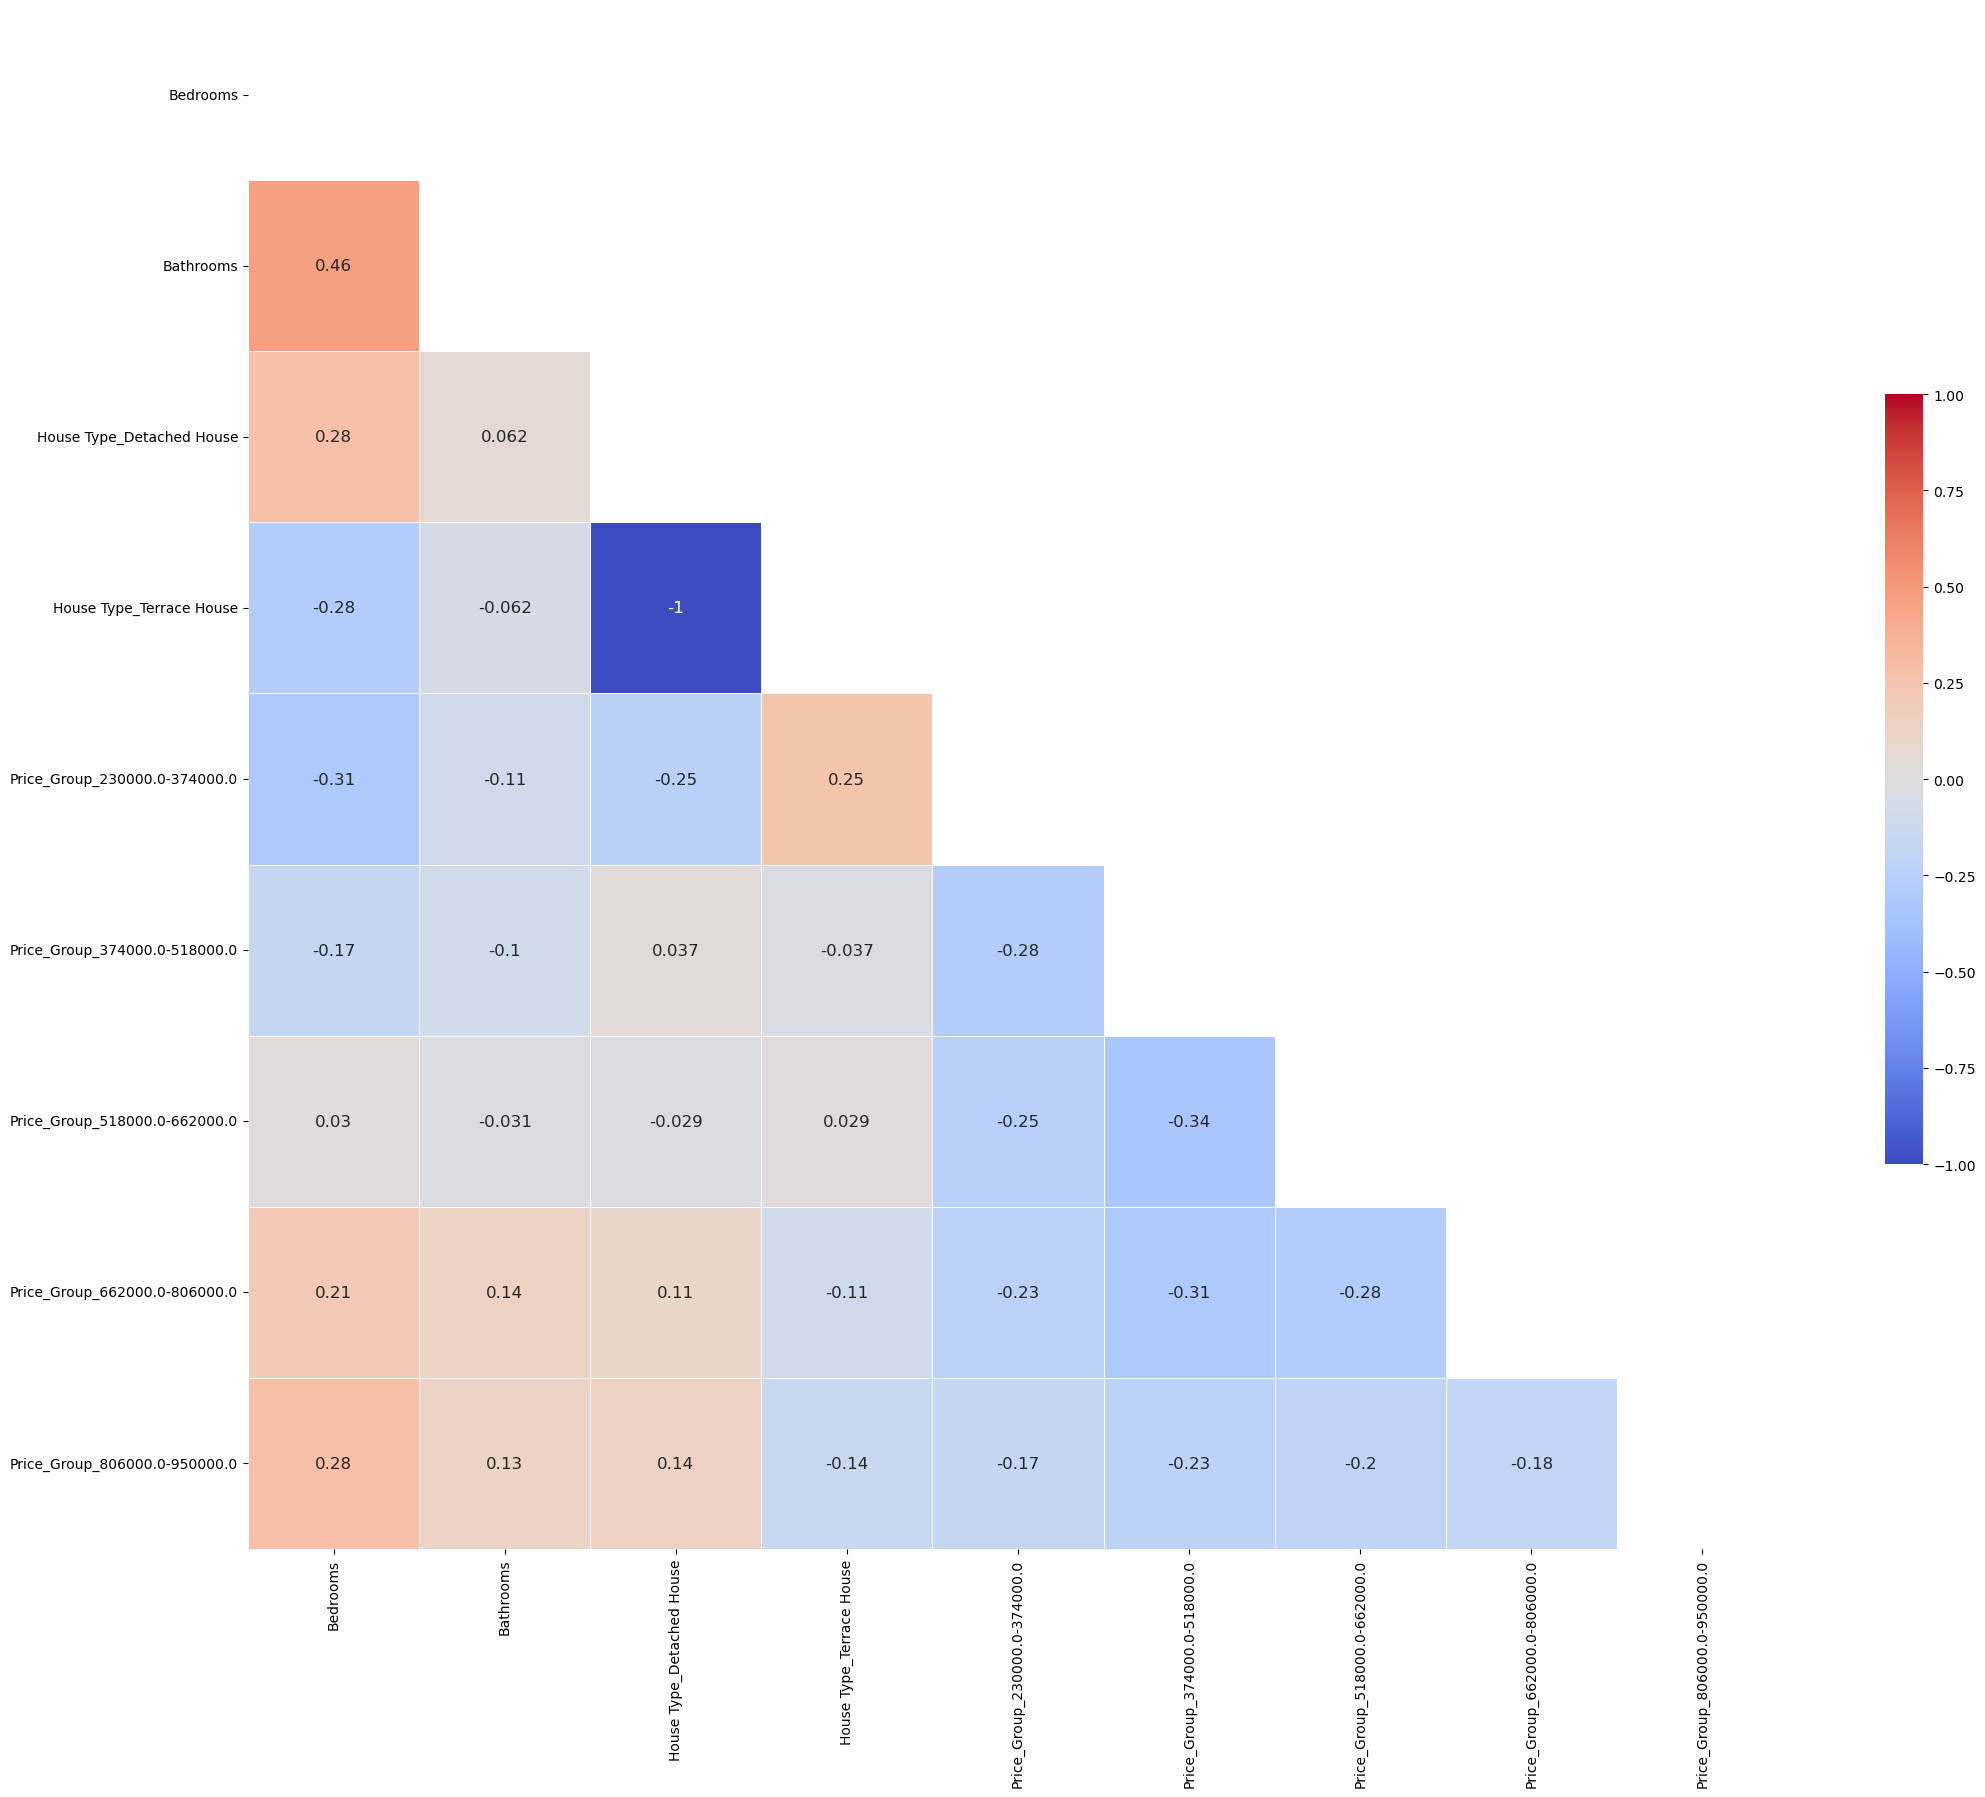

In [22]:
# checking correlation between variables
import numpy as np

# plotting heatmap
corrmat = df_Dublin.corr()

# setting mask for upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# setting hot-cold colour scheme
# cmap = sns.diverging_palette(240, 15, as_cmap=True)
cmap = 'coolwarm'

# plotting the graph
f, ax = plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, square = True, mask=mask, cmap=cmap,
            vmax=1, vmin=-1, center=0,
            annot = True, annot_kws = {'size': 12},
            linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [23]:
# importing libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [24]:
# separating features and target variable
X = df_Dublin.drop('District', axis=1)
y = df_Dublin['District']

In [25]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
df_Dublin.head()

,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0
0,3,2,Dublin,0,1,0,0,1,0,0
2,4,3,County,1,0,0,0,0,1,0
3,4,5,County,1,0,0,0,0,1,0
4,3,3,County,1,0,0,1,0,0,0
5,4,2,County,1,0,0,0,1,0,0


## 2.3. KNN
#### a) Standard code

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# creating a KNN classifier with k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# training the model on the training set
knn.fit(X_train, y_train)

# predicting the target variable for the test set
y_pred = knn.predict(X_test)

# calculating the model results
accuracy_KNN = accuracy_score(y_test, y_pred)
precision_KNN = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_KNN = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN}")
print(f"Precision: {precision_KNN}")
print(f"Recall: {recall_KNN}")
print(f"F1 Score: {f1_KNN}")
print("Confusion Matrix:")
print(confusion_mat_KNN)

Evaluation Metrics:
Accuracy: 0.6511627906976745
Precision: 0.746031746031746
Recall: 0.7704918032786885
F1 Score: 0.7580645161290323
Confusion Matrix:
[[ 9 16]
 [14 47]]


In [28]:
# checking size of each class
from collections import Counter

# summarizing class distribution
print("Before oversampling: ",Counter(y_train))

Before oversampling:  Counter({'Dublin': 225, 'County': 119})


#### b) Addressing class imbalance - SMOTE

In [29]:
# oversampling using SMOTE
from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

In [30]:
# creating a KNN classifier with k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# appling the transformation
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# training the model on the training set
knn.fit(X_train_SMOTE, y_train_SMOTE)

# predicting the target variable for the test set
y_pred = knn.predict(X_test)

# evaluating the model
accuracy_KNN2 = accuracy_score(y_test, y_pred)
precision_KNN2 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN2 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN2 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_KNN2 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN2}")
print(f"Precision: {precision_KNN2}")
print(f"Recall: {recall_KNN2}")
print(f"F1 Score: {f1_KNN2}")
print("Confusion Matrix:")
print(confusion_mat_KNN2)

Evaluation Metrics:
Accuracy: 0.627906976744186
Precision: 0.7457627118644068
Recall: 0.7213114754098361
F1 Score: 0.7333333333333334
Confusion Matrix:
[[10 15]
 [17 44]]


In [31]:
# summarizing class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({'County': 225, 'Dublin': 225})


#### c) Addressing class imbalance - BorderlineSMOTE

In [32]:
from imblearn.over_sampling import BorderlineSMOTE

# Aapling Borderline-SMOTE to oversample the minority class
Bsmote = BorderlineSMOTE()
X_train_Bsmote, y_train_Bsmote = Bsmote.fit_resample(X_train, y_train)

# creating a new KNN model with the optimal value of K
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# training the model on the oversampled training set
knn.fit(X_train_Bsmote, y_train_Bsmote)

# pedicting the target variable for the test set
y_pred = knn.predict(X_test)

# calculating the model results
accuracy_KNN3 = accuracy_score(y_test, y_pred)
precision_KNN3 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN3 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN3 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_KNN3 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN3}")
print(f"Precision: {precision_KNN3}")
print(f"Recall: {recall_KNN3}")
print(f"F1 Score: {f1_KNN3}")
print("Confusion Matrix:")
print(confusion_mat_KNN3)

Evaluation Metrics:
Accuracy: 0.6162790697674418
Precision: 0.7413793103448276
Recall: 0.7049180327868853
F1 Score: 0.7226890756302522
Confusion Matrix:
[[10 15]
 [18 43]]


#### d) Addressing class imbalance - SMOTEENN

In [33]:
from imblearn.combine import SMOTEENN

# appling SMOTE-ENN to oversample and undersample the data
smote_enn = SMOTEENN()
X_train_enn, y_train_enn = smote_enn.fit_resample(X_train, y_train)

# creating a new KNN model with the optimal value of K
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# training the model on the resampled training set
knn.fit(X_train_enn, y_train_enn)

# predicting the target variable for the test set
y_pred = knn.predict(X_test)

# calculating the model results
accuracy_KNN4 = accuracy_score(y_test, y_pred)
precision_KNN4 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN4 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN4 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the confusion matrix
confusion_mat_KNN4 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print("Evaluation Metrics:")
print(f"Accuracy: {accuracy_KNN4}")
print(f"Precision: {precision_KNN4}")
print(f"Recall: {recall_KNN4}")
print(f"F1 Score: {f1_KNN4}")
print("Confusion Matrix:")
print(confusion_mat_KNN4)

Evaluation Metrics:
Accuracy: 0.6162790697674418
Precision: 0.7258064516129032
Recall: 0.7377049180327869
F1 Score: 0.7317073170731708
Confusion Matrix:
[[ 8 17]
 [16 45]]


#### e) selecting best parameters

In [34]:
#defining the parameter grid
param_grid = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
              'weights': ['uniform', 'distance']}

# creating a KNN classifier
knn = KNeighborsClassifier()

In [35]:
# performming grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

# training the model on the training set
knn_best.fit(X_train, y_train)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp = accuracy_score(y_test, y_pred)
precision_KNN_hyp = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculating confusion matrix
confusion_mat_KNN_hyp = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp}")
print(f"Precision: {precision_KNN_hyp}")
print(f"Recall: {recall_KNN_hyp}")
print(f"F1 Score: {f1_KNN_hyp}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp)

Best Hyperparameters:
{'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.627906976744186
Precision: 0.7301587301587301
Recall: 0.7540983606557377
F1 Score: 0.7419354838709677
Confusion Matrix:
[[ 8 17]
 [15 46]]


In [36]:
# performming grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_SMOTE, y_train_SMOTE)

#getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

#training the model on the training set
knn_best.fit(X_train_SMOTE, y_train_SMOTE)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp2 = accuracy_score(y_test, y_pred)
precision_KNN_hyp2 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp2 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp2 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_KNN_hyp2 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp2}")
print(f"Precision: {precision_KNN_hyp2}")
print(f"Recall: {recall_KNN_hyp2}")
print(f"F1 Score: {f1_KNN_hyp2}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp2)

Best Hyperparameters:
{'n_neighbors': 14, 'weights': 'uniform'}
Accuracy: 0.5465116279069767
Precision: 0.7037037037037037
Recall: 0.6229508196721312
F1 Score: 0.6608695652173914
Confusion Matrix:
[[ 9 16]
 [23 38]]


In [37]:
# performming the grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_Bsmote, y_train_Bsmote)

# getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

# training the model on the training set
knn_best.fit(X_train_Bsmote, y_train_Bsmote)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp3 = accuracy_score(y_test, y_pred)
precision_KNN_hyp3 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp3 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp3 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculate confusion matrix
confusion_mat_KNN_hyp3 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp3}")
print(f"Precision: {precision_KNN_hyp3}")
print(f"Recall: {recall_KNN_hyp3}")
print(f"F1 Score: {f1_KNN_hyp3}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp3)

Best Hyperparameters:
{'n_neighbors': 2, 'weights': 'distance'}
Accuracy: 0.5348837209302325
Precision: 0.7692307692307693
Recall: 0.4918032786885246
F1 Score: 0.6
Confusion Matrix:
[[16  9]
 [31 30]]


In [38]:
# performming grid search to find the best hyperparameters
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_enn, y_train_enn)

# getting the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# creating a new KNN classifier with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])

# training the model on the training set
knn_best.fit(X_train_enn, y_train_enn)

# predicting the target variable for the test set
y_pred = knn_best.predict(X_test)

# calculating the model results
accuracy_KNN_hyp4 = accuracy_score(y_test, y_pred)
precision_KNN_hyp4 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_KNN_hyp4 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_KNN_hyp4 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculate confusion matrix
confusion_mat_KNN_hyp4 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_KNN_hyp4}")
print(f"Precision: {precision_KNN_hyp4}")
print(f"Recall: {recall_KNN_hyp4}")
print(f"F1 Score: {f1_KNN_hyp4}")
print("Confusion Matrix:")
print(confusion_mat_KNN_hyp4)

Best Hyperparameters:
{'n_neighbors': 2, 'weights': 'distance'}
Accuracy: 0.5697674418604651
Precision: 0.7307692307692307
Recall: 0.6229508196721312
F1 Score: 0.672566371681416
Confusion Matrix:
[[11 14]
 [23 38]]


### saving KNN results in a df

In [39]:
data = {
    'Type': ['Original', 'SMOTE', 'BorderlineSMOTE', 'SMOTEENN'],
    'Accuracy': [accuracy_KNN_hyp, accuracy_KNN_hyp2, accuracy_KNN_hyp3, accuracy_KNN_hyp4],
    'Precision': [precision_KNN_hyp, precision_KNN_hyp2, precision_KNN_hyp3, precision_KNN_hyp4],
    'Recall': [recall_KNN_hyp, recall_KNN_hyp2, recall_KNN_hyp3, recall_KNN_hyp4],
    'F1': [f1_KNN_hyp, f1_KNN_hyp2, f1_KNN_hyp3, f1_KNN_hyp4],
    'Confusion Matrix': [confusion_mat_KNN_hyp, confusion_mat_KNN_hyp2, confusion_mat_KNN_hyp3, confusion_mat_KNN_hyp4]
}

# Create the DataFrame
df_KNN_results = pd.DataFrame(data)
df_KNN_results

,Type,Accuracy,Precision,Recall,F1,Confusion Matrix
0,Original,0.627907,0.730159,0.754098,0.741935,"[[8, 17], [15, 46]]"
1,SMOTE,0.546512,0.703704,0.622951,0.660870,"[[9, 16], [23, 38]]"
2,BorderlineSMOTE,0.534884,0.769231,0.491803,0.600000,"[[16, 9], [31, 30]]"
3,SMOTEENN,0.569767,0.730769,0.622951,0.672566,"[[11, 14], [23, 38]]"


# Random Forest
### a) Standard code

In [40]:
from sklearn.ensemble import RandomForestClassifier

# creating a random forest classifier
rf_classifier = RandomForestClassifier()

# trainning the model
rf_classifier.fit(X_train, y_train)

# making the predictions on the test data
y_pred = rf_classifier.predict(X_test)

# calculating the model results
accuracy_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred,pos_label='Dublin')
recall_rf = recall_score(y_test, y_pred,pos_label='Dublin')
f1_rf = f1_score(y_test, y_pred,pos_label='Dublin')

# calculating confusion matrix
confusion_mat_rf = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print("Confusion Matrix:")
print(confusion_mat_rf)

Accuracy: 0.6511627906976745
Precision: 0.746031746031746
Recall: 0.7704918032786885
F1 Score: 0.7580645161290323
Confusion Matrix:
[[ 9 16]
 [14 47]]


#### b) Hyperparameters search

In [41]:
# defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# creating a random forest classifier
rf_classifier = RandomForestClassifier()

# creating GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# fitting the model on the SMOTE training set
grid_search.fit(X_train, y_train)

# getting the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# making predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# calculating the model results
accuracy_rf1 = accuracy_score(y_test, y_pred)
precision_rf1 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_rf1 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_rf1 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating confusion matrix
confusion_mat_rf1 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics, best hyperparameters, and confusion matrix
print(f"Accuracy: {accuracy_rf1}")
print(f"Precision: {precision_rf1}")
print(f"Recall: {recall_rf1}")
print(f"F1 Score: {f1_rf1}")

print("Confusion Matrix:")
print(confusion_mat_rf1)

print("Best Hyperparameters:")
print(best_params)

Accuracy: 0.6976744186046512
Precision: 0.7464788732394366
Recall: 0.8688524590163934
F1 Score: 0.803030303030303
Confusion Matrix:
[[ 7 18]
 [ 8 53]]
Best Hyperparameters:
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


#### c) Boosting

In [46]:
from sklearn.ensemble import AdaBoostClassifier

# creating the base estimator with the best hyperparameters
base_estimator = RandomForestClassifier(max_depth= 5, min_samples_leaf= 2, min_samples_split= 5, n_estimators= 300)

# creating the AdaBoost classifier with the base estimator
boosted_classifier = AdaBoostClassifier(base_estimator=base_estimator)

# fitting the model on the SMOTE training set
boosted_classifier.fit(X_train, y_train)

# making predictions on the test data
y_pred = boosted_classifier.predict(X_test)

# calculating the model results
accuracy_boosted = accuracy_score(y_test, y_pred)
precision_boosted = precision_score(y_test, y_pred, pos_label='Dublin')
recall_boosted = recall_score(y_test, y_pred, pos_label='Dublin')
f1_boosted = f1_score(y_test, y_pred, pos_label='Dublin')

# calculate confusion matrix
confusion_mat_boosted = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_boosted}")
print(f"Precision: {precision_boosted}")
print(f"Recall: {recall_boosted}")
print(f"F1 Score: {f1_boosted}")
print("Confusion Matrix:")
print(confusion_mat_boosted)

Accuracy: 0.6511627906976745
Precision: 0.746031746031746
Recall: 0.7704918032786885
F1 Score: 0.7580645161290323
Confusion Matrix:
[[ 9 16]
 [14 47]]


#### d) Bagging

In [47]:
from sklearn.ensemble import BaggingClassifier

# creating the base estimator with the best hyperparameters
base_estimator = RandomForestClassifier(max_depth= 5, min_samples_leaf= 2, min_samples_split= 5, n_estimators= 300)

# creating the Bagging classifier with the base estimator
bagging_classifier = BaggingClassifier(base_estimator=base_estimator)

# fitting the model on the SMOTE training set
bagging_classifier.fit(X_train, y_train)

# making predictions on the test data
y_pred = bagging_classifier.predict(X_test)

# calculating the model results
accuracy_bagging = accuracy_score(y_test, y_pred)
precision_bagging = precision_score(y_test, y_pred, pos_label='Dublin')
recall_bagging = recall_score(y_test, y_pred, pos_label='Dublin')
f1_bagging = f1_score(y_test, y_pred, pos_label='Dublin')

# Calculate confusion matrix
confusion_mat_bagging = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_bagging}")
print(f"Precision: {precision_bagging}")
print(f"Recall: {recall_bagging}")
print(f"F1 Score: {f1_bagging}")
print("Confusion Matrix:")
print(confusion_mat_bagging)

Accuracy: 0.7209302325581395
Precision: 0.7466666666666667
Recall: 0.9180327868852459
F1 Score: 0.823529411764706
Confusion Matrix:
[[ 6 19]
 [ 5 56]]


#### e) Saving the results

In [48]:
data1 = {
    'Type': ['Original', 'ParamGrid', 'Boosting', 'Bagging'],
    'Accuracy': [accuracy_rf, accuracy_rf1, accuracy_boosted, accuracy_bagging],
    'Precision': [precision_rf, precision_rf1, precision_boosted, precision_bagging],
    'Recall': [recall_rf, recall_rf1, recall_boosted, recall_bagging],
    'F1': [f1_rf, f1_rf1, f1_boosted, f1_bagging],
    'Confusion Matrix': [confusion_mat_rf, confusion_mat_rf1, confusion_mat_boosted, confusion_mat_bagging]
}

# creating the DataFrame
df_RF_results = pd.DataFrame(data1)
df_RF_results

,Type,Accuracy,Precision,Recall,F1,Confusion Matrix
0,Original,0.651163,0.746032,0.770492,0.758065,"[[9, 16], [14, 47]]"
1,ParamGrid,0.697674,0.746479,0.868852,0.803030,"[[7, 18], [8, 53]]"
2,Boosting,0.651163,0.746032,0.770492,0.758065,"[[9, 16], [14, 47]]"
3,Bagging,0.720930,0.746667,0.918033,0.823529,"[[6, 19], [5, 56]]"


### Random Forest - SMOTE
#### a) Standard code

In [50]:
# appling the transformation
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# training the model on the training set
rf_classifier.fit(X_train_SMOTE, y_train_SMOTE)

# making predictions on the test data
y_pred = rf_classifier.predict(X_test)

# calculating the model results
accuracy_sm = accuracy_score(y_test, y_pred)
precision_sm = precision_score(y_test, y_pred,pos_label='Dublin')
recall_sm = recall_score(y_test, y_pred,pos_label='Dublin')
f1_sm = f1_score(y_test, y_pred,pos_label='Dublin')

# calculating confusion matrix
confusion_mat_sm = confusion_matrix(y_test, y_pred)

# Printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_sm}")
print(f"Precision: {precision_sm}")
print(f"Recall: {recall_sm}")
print(f"F1 Score: {f1_sm}")
print("Confusion Matrix:")
print(confusion_mat_sm)

Accuracy: 0.5581395348837209
Precision: 0.7169811320754716
Recall: 0.6229508196721312
F1 Score: 0.6666666666666666
Confusion Matrix:
[[10 15]
 [23 38]]


#### b) Hyperparameter Tuning

In [51]:
# defining the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# creating a random forest classifier
rf_classifier = RandomForestClassifier()

# creating GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# fitting the model on the SMOTE training set
grid_search.fit(X_train_SMOTE, y_train_SMOTE)

# getting the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# making predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# calculating evaluation metrics
accuracy_sm2 = accuracy_score(y_test, y_pred)
precision_sm2 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_sm2 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_sm2 = f1_score(y_test, y_pred, pos_label='Dublin')

# calculating the model results
confusion_mat_sm2 = confusion_matrix(y_test, y_pred)

# printting the evaluation metrics, best hyperparameters, and confusion matrix
print(f"Accuracy: {accuracy_sm2}")
print(f"Precision: {precision_sm2}")
print(f"Recall: {recall_sm2}")
print(f"F1 Score: {f1_sm2}")

print("Confusion Matrix:")
print(confusion_mat_sm2)

print("Best Hyperparameters:")
print(best_params)

Accuracy: 0.5348837209302325
Precision: 0.6981132075471698
Recall: 0.6065573770491803
F1 Score: 0.6491228070175438
Confusion Matrix:
[[ 9 16]
 [24 37]]
Best Hyperparameters:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


#### c) Boosting

In [52]:
# creating the base estimator with the best hyperparameters
base_estimator = RandomForestClassifier(max_depth = 10, min_samples_leaf= 2, min_samples_split=2, n_estimators= 300)

# creating the AdaBoost classifier with the base estimator
boosted_classifier = AdaBoostClassifier(base_estimator=base_estimator)

# fitting the model on the SMOTE training set
boosted_classifier.fit(X_train_SMOTE, y_train_SMOTE)

# making predictions on the test data
y_pred = boosted_classifier.predict(X_test)

# calculating the model results
accuracy_sm3 = accuracy_score(y_test, y_pred)
precision_sm3 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_sm3 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_sm3 = f1_score(y_test, y_pred, pos_label='Dublin')

# confusion matrix
confusion_mat_sm3 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_sm3}")
print(f"Precision: {precision_sm3}")
print(f"Recall: {recall_sm3}")
print(f"F1 Score: {f1_sm3}")
print("Confusion Matrix:")
print(confusion_mat_sm3)

Accuracy: 0.5232558139534884
Precision: 0.7
Recall: 0.5737704918032787
F1 Score: 0.6306306306306306
Confusion Matrix:
[[10 15]
 [26 35]]


#### d) Bagging

In [54]:
# creating the base estimator with the best hyperparameters
base_estimator = RandomForestClassifier(max_depth = 10, min_samples_leaf= 2, min_samples_split=2, n_estimators= 300)

# creating the Bagging classifier with the base estimator
bagging_classifier = BaggingClassifier(base_estimator=base_estimator)

# fitting the model on the SMOTE training set
bagging_classifier.fit(X_train_SMOTE, y_train_SMOTE)

#making predictions on the test data
y_pred = bagging_classifier.predict(X_test)

# calculating the model results
accuracy_sm4 = accuracy_score(y_test, y_pred)
precision_sm4 = precision_score(y_test, y_pred, pos_label='Dublin')
recall_sm4 = recall_score(y_test, y_pred, pos_label='Dublin')
f1_sm4 = f1_score(y_test, y_pred, pos_label='Dublin')

# confusion matrix
confusion_mat_sm4 = confusion_matrix(y_test, y_pred)

# printing the evaluation metrics and confusion matrix
print(f"Accuracy: {accuracy_sm4}")
print(f"Precision: {precision_sm4}")
print(f"Recall: {recall_sm4}")
print(f"F1 Score: {f1_sm4}")
print("Confusion Matrix:")
print(confusion_mat_sm4)

Accuracy: 0.5465116279069767
Precision: 0.7037037037037037
Recall: 0.6229508196721312
F1 Score: 0.6608695652173914
Confusion Matrix:
[[ 9 16]
 [23 38]]


#### e) Saving the results

In [57]:
data2= {
    'Type': ['SMOTE', 'SMOTE + HYP-PARAM', 'SMOTE + Boosting', 'SMOTE + Bagging'],
    'Accuracy': [accuracy_sm, accuracy_sm2, accuracy_sm3, accuracy_sm4],
    'Precision': [precision_sm, precision_sm2, precision_sm3, precision_sm4],
    'Recall': [recall_sm, recall_sm2, recall_sm3, recall_sm4],
    'F1': [f1_sm, f1_sm2, f1_sm3, f1_sm4],
    'Confusion Matrix': [confusion_mat_sm, confusion_mat_sm2, confusion_mat_sm3, confusion_mat_sm4]
}

# creating the DataFrame
df_RF_SM_results = pd.DataFrame(data2)
df_RF_SM_results

,Type,Accuracy,Precision,Recall,F1,Confusion Matrix
0,SMOTE,0.558140,0.716981,0.622951,0.666667,"[[10, 15], [23, 38]]"
1,SMOTE + HYP-PARAM,0.534884,0.698113,0.606557,0.649123,"[[9, 16], [24, 37]]"
2,SMOTE + Boosting,0.523256,0.700000,0.573770,0.630631,"[[10, 15], [26, 35]]"
3,SMOTE + Bagging,0.546512,0.703704,0.622951,0.660870,"[[9, 16], [23, 38]]"


In [58]:
# Append df_RF_SM_results to df_RF_results
df_RF_results = df_RF_results.append(df_RF_SM_results, ignore_index=True)

# Print the updated df_RF_results
df_RF_results

C:\Users\ester\AppData\Local\Temp\ipykernel_9100\3187328505.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_RF_results = df_RF_results.append(df_RF_SM_results, ignore_index=True)


,Type,Accuracy,Precision,Recall,F1,Confusion Matrix
0,Original,0.651163,0.746032,0.770492,0.758065,"[[9, 16], [14, 47]]"
1,ParamGrid,0.697674,0.746479,0.868852,0.803030,"[[7, 18], [8, 53]]"
2,Boosting,0.651163,0.746032,0.770492,0.758065,"[[9, 16], [14, 47]]"
3,Bagging,0.720930,0.746667,0.918033,0.823529,"[[6, 19], [5, 56]]"
4,SMOTE,0.558140,0.716981,0.622951,0.666667,"[[10, 15], [23, 38]]"
5,SMOTE + HYP-PARAM,0.534884,0.698113,0.606557,0.649123,"[[9, 16], [24, 37]]"
6,SMOTE + Boosting,0.523256,0.700000,0.573770,0.630631,"[[10, 15], [26, 35]]"
7,SMOTE + Bagging,0.546512,0.703704,0.622951,0.660870,"[[9, 16], [23, 38]]"


# Unsupervised ml

In [59]:
df_Dublin.head()

,Bedrooms,Bathrooms,District,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0
0,3,2,Dublin,0,1,0,0,1,0,0
2,4,3,County,1,0,0,0,0,1,0
3,4,5,County,1,0,0,0,0,1,0
4,3,3,County,1,0,0,1,0,0,0
5,4,2,County,1,0,0,0,1,0,0


In [60]:
# getting dummies for 'House Type' column
df_Dublin = pd.get_dummies(df_Dublin, columns=['District'])

df_Dublin.head()

,Bedrooms,Bathrooms,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0,District_County,District_Dublin
0,3,2,0,1,0,0,1,0,0,0,1
2,4,3,1,0,0,0,0,1,0,1,0
3,4,5,1,0,0,0,0,1,0,1,0
4,3,3,1,0,0,1,0,0,0,1,0
5,4,2,1,0,0,0,1,0,0,1,0


In [61]:
# checking how many missing values is in columns
df_Dublin.isna().sum() 

Bedrooms                         0
Bathrooms                        0
House Type_Detached House        0
House Type_Terrace House         0
Price_Group_230000.0-374000.0    0
Price_Group_374000.0-518000.0    0
Price_Group_518000.0-662000.0    0
Price_Group_662000.0-806000.0    0
Price_Group_806000.0-950000.0    0
District_County                  0
District_Dublin                  0
dtype: int64

In [63]:
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest model
model = IsolationForest()

# Fit the model to the data
model.fit(df_Dublin)

# Predict anomaly scores for each data point
anomaly_scores = model.decision_function(df_Dublin)

In [64]:
# Add the anomaly scores as a new column in df_Dublin
df_Dublin['Anomaly Score'] = anomaly_scores
df_Dublin.head()

,Bedrooms,Bathrooms,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0,District_County,District_Dublin,Anomaly Score
0,3,2,0,1,0,0,1,0,0,0,1,0.023585
2,4,3,1,0,0,0,0,1,0,1,0,0.010911
3,4,5,1,0,0,0,0,1,0,1,0,-0.100937
4,3,3,1,0,0,1,0,0,0,1,0,0.032270
5,4,2,1,0,0,0,1,0,0,1,0,-0.040784


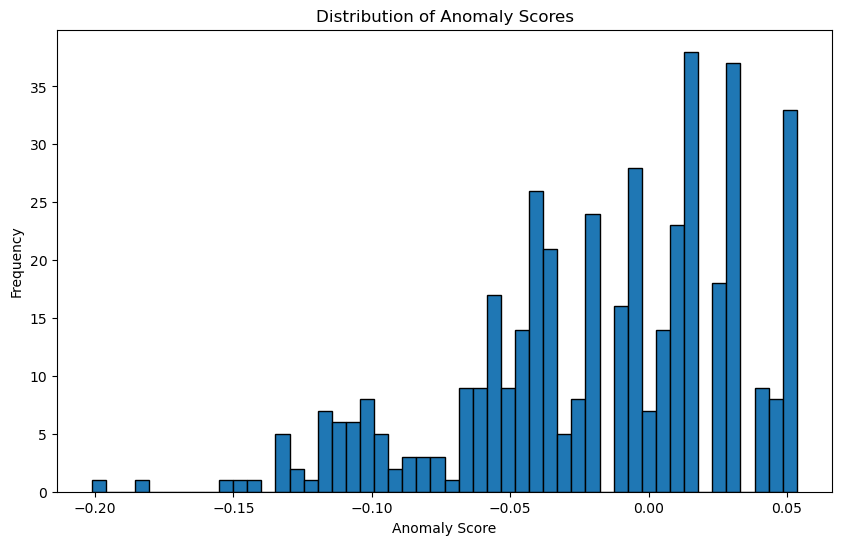

In [65]:

plt.figure(figsize=(10, 6))
plt.hist(df_Dublin['Anomaly Score'], bins=50, edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.show()

In [66]:
anomaly_threshold = -0.15
anomaly_rows = df_Dublin[df_Dublin['Anomaly Score'] < anomaly_threshold]
anomaly_rows

,Bedrooms,Bathrooms,House Type_Detached House,House Type_Terrace House,Price_Group_230000.0-374000.0,Price_Group_374000.0-518000.0,Price_Group_518000.0-662000.0,Price_Group_662000.0-806000.0,Price_Group_806000.0-950000.0,District_County,District_Dublin,Anomaly Score
433,8,6,0,1,0,0,0,1,0,0,1,-0.201017
835,5,5,1,0,0,0,1,0,0,1,0,-0.151684
852,6,6,0,1,0,0,1,0,0,0,1,-0.181513
